# Figure S3 Definition of probability distributions in the calculation of mutual information.

In [24]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO
from scipy.stats import entropy


# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

### Loading input data

In [25]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [26]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [27]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [28]:
O1_1027_raw = np.load('../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [29]:
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

crp_emat_raw = pd.read_table('../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

/var/folders/67/2rd1gct91876bvjs_7ny9rcw0000gn/T/ipykernel_57830/4194569494.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  crp_emat_raw = pd.read_table('../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)


### Using ACGT instead of wild-type vs. mutant

In [30]:
n_NS = len(genome)
ep_wt, er_wt, ea_wt = -2, -13, -13
e_int = -10
n_p, n_r, n_a = 5000, 50, 50

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP'), (2, 17, 'R', 'LacI')]

In [31]:
stn_ratio_cg = []
stn_ratio_wcg = []
for i in range(20):
    df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        num_mutants=5000)
    
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    nbins = 2
    upper_bound = np.mean(mu_data)
    n_seqs = len(mut_list)
    len_promoter = 160
    pseudocount = 10**(-6)

    footprint_cg = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))
    total_signal = 0
    for region in region_params:
        total_signal += np.sum(footprint_cg[(region[0]+115):(region[1]+116)])
    stn_ratio = total_signal / (np.sum(footprint_cg) - total_signal)
    stn_ratio_cg.append(stn_ratio)

    mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
    p_mu = tregs.footprint.get_p_mu(bin_cnt, n_seqs)

    letters = ['A', 'T', 'C', 'G']

    list_p_b = []
    for position in range(len_promoter):
        dict_cnt = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
        for mut in mut_list:
            mut = mut.upper()
            letter = mut[position]
            dict_cnt[letter] += 1
        list_cnt = []
        for letter in letters:
            list_cnt.append(dict_cnt[letter])
        p_b = np.asarray(list_cnt) / n_seqs
        list_p_b.append(p_b)

    list_joint_p = []
    for position in range(len_promoter):
        joint_p = np.zeros((4, nbins)) + pseudocount
        # adding a pseudocount to prevent zero-division error
        for i, mut in enumerate(mut_list):
            mut = mut.upper()
            for j in range(nbins):
                for i_letter in range(4):
                    if (mut[position] == letters[i_letter]) & (mu_bins[i] == j):
                        joint_p[i_letter][j] += 1

        joint_p /= np.sum(joint_p)
        list_joint_p.append(joint_p)

    footprint_wcg = []
    for position in range(len_promoter):
        p_b = list_p_b[position]
        joint_p = list_joint_p[position]

        mi = 0
        for i in range(len(p_mu)):
            for i_letter in range(4):
                mi += joint_p[i_letter][i] * np.log2(joint_p[i_letter][i] / (p_b[i_letter] * p_mu[i]))
        footprint_wcg.append(mi)

    total_signal = 0
    for region in region_params:
        total_signal += np.sum(footprint_wcg[(region[0]+115):(region[1]+116)])
    stn_ratio = total_signal / (np.sum(footprint_wcg) - total_signal)
    stn_ratio_wcg.append(stn_ratio)

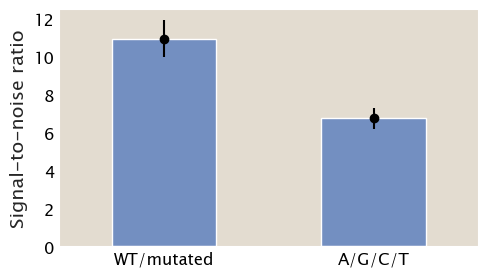

In [32]:
fig, ax = plt.subplots(figsize=(5.2,3))

x = ['WT/mutated', 'A/G/C/T']
y = [np.mean(stn_ratio_cg), np.mean(stn_ratio_wcg)]

ax.bar(x, y, width=0.5, color='#738FC1', edgecolor=None, align='center')
ax.errorbar(x, y, yerr=[np.std(stn_ratio_cg), np.std(stn_ratio_wcg)], fmt="o", color='black')
#ax.set_xticks(x, label=x_ticks)
ax.set_ylabel('Signal-to-noise ratio', fontsize=14)
ax.set_xlim(-0.5, 1.5)
 
plt.tight_layout()
plt.savefig('../plots/figS3/stn_atcg.pdf', dpi=300)
plt.show()

**Panel (C) 1)**

In [33]:
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.mean(mu_data)
n_seqs = len(mut_list)
len_promoter = 160
pseudocount = 10**(-6)

mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
p_mu = tregs.footprint.get_p_mu(bin_cnt, n_seqs)

letters = ['A', 'T', 'C', 'G']

list_p_b = []
for position in range(len_promoter):
    dict_cnt = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
    for mut in mut_list:
        mut = mut.upper()
        letter = mut[position]
        dict_cnt[letter] += 1
    list_cnt = []
    for letter in letters:
        list_cnt.append(dict_cnt[letter])
    p_b = np.asarray(list_cnt) / n_seqs
    list_p_b.append(p_b)

list_joint_p = []
for position in range(len_promoter):
    joint_p = np.zeros((4, nbins)) + pseudocount
    # adding a pseudocount to prevent zero-division error
    for i, mut in enumerate(mut_list):
        mut = mut.upper()
        for j in range(nbins):
            for i_letter in range(4):
                if (mut[position] == letters[i_letter]) & (mu_bins[i] == j):
                    joint_p[i_letter][j] += 1

    joint_p /= np.sum(joint_p)
    list_joint_p.append(joint_p)

footprint_wcg = []
for position in range(len_promoter):
    p_b = list_p_b[position]
    joint_p = list_joint_p[position]

    mi = 0
    for i in range(len(p_mu)):
        for i_letter in range(4):
            mi += joint_p[i_letter][i] * np.log2(joint_p[i_letter][i] / (p_b[i_letter] * p_mu[i]))
    footprint_wcg.append(mi)

In [34]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]

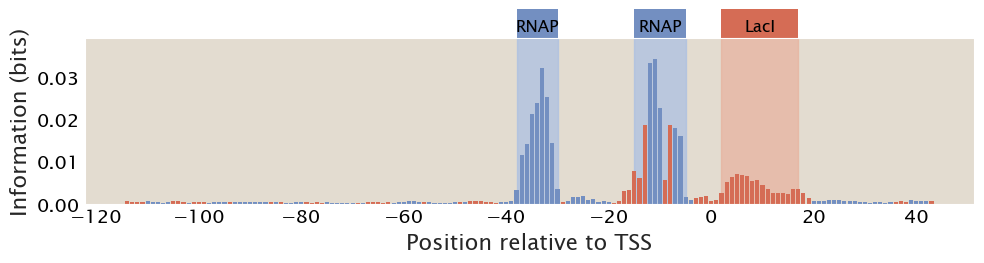

In [35]:
fig, ax = plt.subplots(figsize=(10,2.9))
ax.set_ylabel('Information (bits)', fontsize=16)
ax.set_xlabel('Position relative to TSS', fontsize=16)

footprint = footprint_wcg

windowsize = 3
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregs.utils.smoothing(footprint, windowsize=windowsize)

ax.set_ylim(top=max(footprint_smoothed)*1.15)
max_signal = max(footprint_smoothed)
total_signal = 0
for region in region_params:
    tregs.footprint.label_binding_site(ax, region[0], region[1], max_signal, region[2], region[3])
    total_signal += np.sum(footprint[(region[0]+115):(region[1]+116)])
stn_ratio = total_signal / (np.sum(footprint) - total_signal)

ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors, linewidth=0)

custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig('../plots/figS3/footprint-wcg.pdf')
plt.show()

### Varying bin sizes

In [36]:
n_NS = len(genome)
ep_wt, er_wt, ea_wt = -2, -13, -13
e_int = -10
n_p, n_r, n_a = 4600, 50, 50

df = tregs.simulate.sim(promoter, tregs.simulate.repact_pbound, [rnap_site, rep_site, crp_site],
                        *[n_NS, n_p, n_r, n_a, rnap_emat, rep_emat, crp_emat, ep_wt, er_wt, ea_wt, e_int],
                        num_mutants=5000,
                        scaling_factor=10*6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP'), (2, 17, 'R', 'LacI')]

In [37]:
def get_signal(footprint, region_param):
    signal = np.sum(footprint[(region_param[0]+115):(region_param[1]+116)])
    length = region_param[1] - region_param[0] + 1
    return signal, length

In [38]:
l_nbins = np.arange(2, 11, 1)

l_stn_ratio_rnap10 = []
l_stn_ratio_rnap35 = []
l_stn_ratio_lacI = []
for i in range(len(l_nbins)):
    rnap10 = []
    rnap35 = []
    lacI = []
    for j in range(20):
        nbins = l_nbins[i]

        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        num_mutants=5000)
        
        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.quantile(mu_data, 1 - 1 / nbins)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    l_stn_ratio_rnap10.append(np.mean(rnap10))
    l_stn_ratio_rnap35.append(np.mean(rnap35))
    l_stn_ratio_lacI.append(np.mean(lacI))

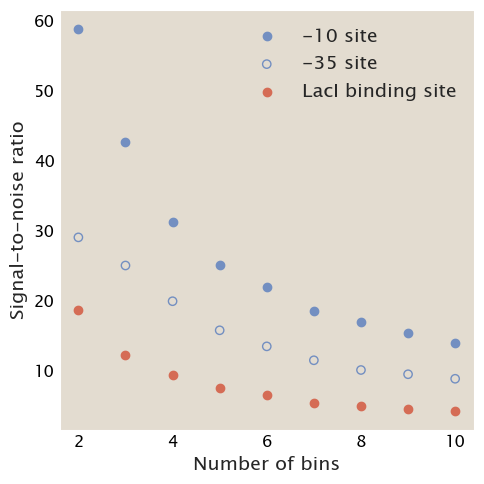

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(l_nbins, l_stn_ratio_rnap10, label='-10 site', color='#738FC1')
ax.scatter(l_nbins, l_stn_ratio_rnap35, label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(l_nbins, l_stn_ratio_lacI, label='LacI binding site',
           color='#D56C55')
ax.set_xlabel('Number of bins', fontsize=14)
ax.set_ylabel('Signal-to-noise ratio',fontsize=14)
ax.legend(loc='upper right', frameon=False, fontsize=14)

plt.tight_layout()
plt.savefig('../plots/figS3/bin-size.pdf')

In [40]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        num_mutants=5000)

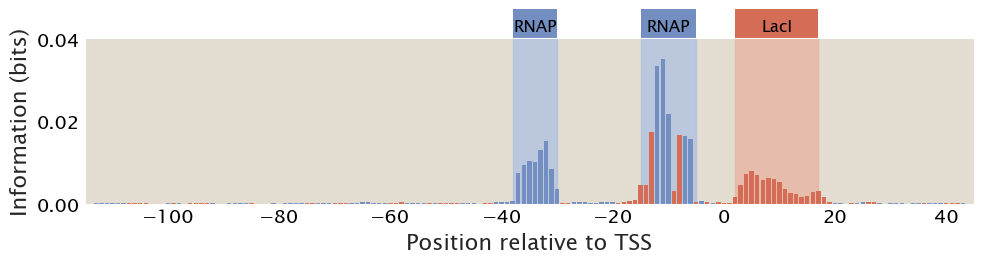

In [41]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2,
                               outfile='../plots/figS3/footprint-cg-2bins.pdf')

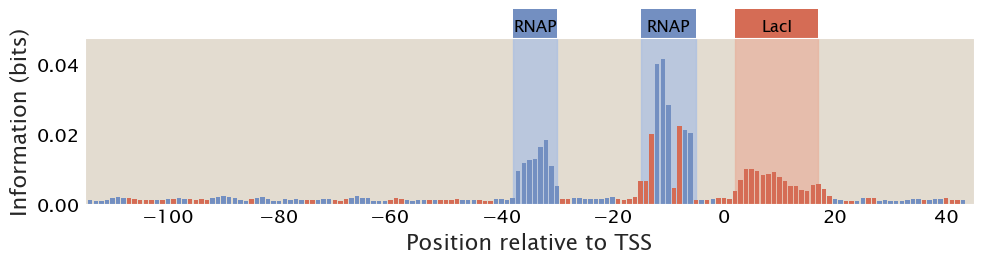

In [42]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=10,
                               outfile='../plots/figS3/footprint-cg-10bins.pdf')